In [1]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

#restart runtime and continue execution from cell below

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
!pip install contractions
!pip install demoji
import spacy
import spacy.cli

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 517.6 kB/s eta 0:00:00


In [2]:
import re
import string
import pandas as pd
from pathlib import Path
from collections import defaultdict

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re
import regex
import string
import unicodedata
import contractions
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

import locale
locale.getpreferredencoding = lambda: "UTF-8"

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
def tokenize_ngram(text):
  if isinstance(text, str) and len(text) > 0:
    text = text.replace("front end", "frontend").replace("back end", "backend")
    toks = word_tokenize(text)
    unigrams_ls, bigrams_ls, new_toks = [], [], []
    for tok in toks:
      # split sentence by punctuation or stopword
      if tok[0].isalpha() and tok not in stopwords.words('english'):
        # remove punctuation within word
        tok = re.sub('[%s]' % re.escape(string.punctuation), '', tok)
        new_toks.append(tok)
      else: # extract ngrams of split sentence
        if len(new_toks) > 0:
          unigrams_ls += new_toks
          bigrams_ls += [" ".join(ngram) for ngram in nltk.ngrams(new_toks, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>')]
          new_toks = []
    # extract ngrams of the rest of sentence
    if len(new_toks) > 0:
      unigrams_ls += new_toks
      bigrams_ls += [" ".join(ngram) for ngram in nltk.ngrams(new_toks, 2, pad_left=True, pad_right=True, left_pad_symbol='<s>', right_pad_symbol='</s>')]
      new_toks = []

    # return unigrams and bigrams separated by " || "
    # each separated by " | "
    ngrams_ls = []
    if len(unigrams_ls) == 0 and len(bigrams_ls) == 0:
      return None
    for grams in [unigrams_ls, bigrams_ls]:
      if len(grams) != 0:
        ngrams_ls.append(" | ".join(grams))
    return " || ".join(ngrams_ls)#, ngrams_ls
  else:
    return None

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [50]:
# title to occupation csv

#major occupations
mainTitle = {11:'Management',
13:'Business and Financial Ops',
15:'Computer and Mathematical',
17:'Architecture and Engineering',
19:'Life, Physical, and Social Science',
21:'Community and Social Service',
23:'Legal Occupations',
25:'Educational Instruction and Library',
27:'Arts, Design, Entertainment, Sports, and Media',
29:'Healthcare Practitioners and Technical',
31:'Healthcare Support',
33:'Protective Service',
35:'Food Preparation and Serving Related',
37:'Building and Grounds Cleaning and Maintenance',
39:'Personal Care and Service',
41:'Sales and Related',
43:'Office and Administrative Support',
45:'Farming, Fishing, and Forestry',
47:'Construction and Extraction',
49:'Installation, Maintenance, and Repair',
51:'Production',
53:'Transportation and Material Moving',
55:'Military Specific'}
data_dir = "/content/drive/MyDrive/SMM"
title2occupation_df = pd.read_csv(Path(data_dir, 'title_file.csv'), encoding='unicode_escape',).drop_duplicates()
title2occupation_df = title2occupation_df.drop_duplicates()
soc_occupation = []
# Map codes to Occupations
for index, row in title2occupation_df.iterrows():
    code = row['2018 SOC Code'][:2]
    soc_occupation.append(mainTitle[int(code)])

title2occupation_df = title2occupation_df.assign(Occupation=soc_occupation)
title2occupation_df = title2occupation_df.rename(columns={"2018 SOC Title": "Title"})

title2occupation_df = title2occupation_df.drop(columns=['2018 SOC Code','2018 SOC Direct Match Title', 'Illustrative Example'])
title2occupation_df = title2occupation_df.drop_duplicates()
title2occupation_df['Title'] = title2occupation_df['Title'].str.lower()

#lemmatize titles
nlp = spacy.load("en_core_web_lg")
lemmas = []
for doc in nlp.pipe(title2occupation_df["Title"].fillna('')):
  lemmas.append(" ".join(token.lemma_ for token in doc))
title2occupation_df["Title"] = lemmas
title2occupation_df.head()
title2occupation_df.to_csv(Path(data_dir, 'title2OccupationNew.csv'), index=False)

In [51]:
# load curated lists

# title to occupation dictionary
title2occu_df = pd.read_csv(Path(data_dir, 'title2OccupationNew.csv'), encoding='unicode_escape',).drop_duplicates()
def tokenize_titles(title,occupation):
  title = re.sub('[^A-Za-z]+', ' ', title)
  title = ' '.join(word.lower() for word in title.split() if word.lower() not in stopwords.words('english'))
  words = title.split()
  # print(words)
  tups = []
  # title2Occ_dict = {}
  for word in words:
    # title2Occ_dict[word] = occupation
    x = (word, occupation)
    tups.append(x)
  # print(tups)
  return tups
# print(tups)
# tupList = []
title2Occ_temp = title2occu_df.apply(lambda row: tokenize_titles(row['Title'],row['Occupation']),axis =1)
titleList = []
for tupList in title2Occ_temp:
  for tup in tupList:
    titleList.append(tup)
# print(titleList)
title2occupation_df  = pd.DataFrame(titleList, columns = ['Title','Occupation'])
# title2occupation_df.head()


# titles belong to multiple occupation groups are ambiguous
ambiguous = set(title2occupation_df[title2occupation_df.Title.duplicated()].Title.tolist())
unambiguous = set(title2occupation_df.Title.tolist()) - ambiguous
# print(ambiguous)

# each ambiguous titles have a default fallback occupation value,
# in case disambiguation doesnot work
title2occupation_df = title2occupation_df.drop_duplicates(subset=['Title'])
title2occupation_dict = pd.Series(title2occupation_df.Occupation.values, index=title2occupation_df.Title).to_dict()
soc_set_title = list(title2occupation_dict.keys())
assert (unambiguous | ambiguous) == set(soc_set_title)

# modifier2occupation
modifier2occupation = pd.read_csv(Path(data_dir, 'modifier2occupation.csv'))
modifier2occupation = dict(zip(list(modifier2occupation.modifier),list(modifier2occupation.occupation)))

# keyword2occupation
keyword2occupation = pd.read_csv(Path(data_dir, 'keyword2occupation.csv'))
keyword2occupation = dict(zip(list(keyword2occupation.keyword),list(keyword2occupation.occupation)))

In [52]:
def disambiguate(modifier):
  try:
    return modifier2occupation[modifier]
  except KeyError:
    return None

def match_keyword(keyword):
  try:
    return keyword2occupation[keyword]
  except KeyError:
    return None

def extract_occupation(text):
  # print(text)
  if isinstance(text, str):
    unigrams, bigrams = text.split(" || ")
  else:
    return None

  # return first matched title from bigrams and unigrams
  bigrams = bigrams.split(" | ")
  bigrams = [s.split() for s in bigrams]
  for ngram in bigrams:
    # unambiguous title in either position
    for gram in ngram:
      if gram in unambiguous: # 1st position
        assert isinstance(title2occupation_dict[gram], str)
        print(f"unambiguous: {gram} in {ngram}")
        return (' '.join(ngram), title2occupation_dict[gram])
    # ambiguous title @ 2nd position disambiguate by 1st position
    if ngram[1] in ambiguous:
      # print(ngram[0])
      match = disambiguate(ngram[0])
      # print(f"match: {match}")
      if match is not None: # disambiguate success
        assert isinstance(match, str)
        print(f"ambiguous @ 2nd: {ngram[1]} in {ngram}")
        return (' '.join(ngram), match)
    # return ambiguous title @ 1st position, return default occupation
    if ngram[0] in ambiguous:
      assert isinstance(title2occupation_dict[ngram[0]], str)
      print(f"ambiguous @ 1st: {ngram[0]} in {ngram}")
      return (' '.join(ngram), title2occupation_dict[ngram[0]])

  # match keyword in unigrams, cast majority vote, resolve tight by order
  unigrams = unigrams.split(" | ")
  key_occ_ls = []
  key_occ_cnt = defaultdict(int)
  for gram in unigrams:
    match = match_keyword(gram)
    if match is not None:
      assert isinstance(match, str)
      print(f"keyword: {gram}, {match}")
      key_occ_ls.append((gram, match))
      key_occ_cnt[match] += 1

  if len(key_occ_ls) > 0:
    occ, cnt = sorted(key_occ_cnt.items(), key=lambda item: item[1], reverse=True)[0]
    return (cnt, occ)

  return None

In [53]:
import demoji
def remove_emoji(text):
  return demoji.replace(text, '')

# remove hashtag symbol
def replace_hash(text):
  return re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))[#＃]([a-zA-Z0-9_]+)").sub(r'\1', text)

# remove hashtag sequence
def strip_hashtag_sequence(text):
  text = re.compile(r'((^|\s*)[#＃](\w+)){2,}').sub(r' ', text)
  return text

def remove_hashseq_hash_demoji(text):
  text = strip_hashtag_sequence(text)
  text = replace_hash(text)
  text = remove_emoji(text)
  return text

# remove http, @user
def remove_http_user(text):
  text = text.replace("@user", " ")
  text = text.replace("http", " ")
  return " ".join(text.split())


def strip_hashtag(text):
  # if text is not None:
  text = re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))[#＃]([A-Za-z]+[A-Za-z0-9-_]+)").sub(r' ', text)
  return text

def replace_hash(text):
  return re.compile(r"(?<=^|(?<=[^a-zA-Z0-9-_\.]))[#＃]([a-zA-Z0-9_]+)").sub(r'\1', text)

def strip_hashtag_sequence(text):
  text = re.compile(r'((^|\s*)[#＃](\w+)){2,}').sub(r' ', text)
  return text

def strip_url(text):
  text = re.compile(r"https?://\S+|www\.\S+").sub(r' ', text)
  return text

def replace_url(text):
  text = re.compile(r"https?://\S+|www\.\S+").sub(r' http ', text)
  return text

def strip_handle(text):
  # if text is not None:
  # https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer
  HANDLES_RE = regex.compile(
    r"(?<![A-Za-z0-9_!@#\$%&*])@"
    r"(([A-Za-z0-9_]){15}(?!@)|([A-Za-z0-9_]){1,14}(?![A-Za-z0-9_]*@))"
  )
  text = HANDLES_RE.sub(" ", text)
  return text

def replace_handle(text):
  # https://www.nltk.org/_modules/nltk/tokenize/casual.html#TweetTokenizer
  HANDLES_RE = regex.compile(
    r"(?<![A-Za-z0-9_!@#\$%&*])@"
    r"(([A-Za-z0-9_]){15}(?!@)|([A-Za-z0-9_]){1,14}(?![A-Za-z0-9_]*@))"
  )
  text = HANDLES_RE.sub(" @user ", text)
  return text

def strip_handle_hashtag_url(text):
  if text is not None:
    text = strip_handle(text)
    text = strip_hashtag(text)
    text = strip_url(text)
  return text


def remove_digits(text):
  if isinstance(text, str):
    text = [word for word in text.split() if word.isalpha()]
    return " ".join(text)
  else:
    return None

def clean_description(text):
  if isinstance(text, str):
    text = text.lower()
    text = text.replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')
    text = text.replace("’", "'").replace("'s", '')
    text = strip_url(text)
    text = strip_handle(text)
    text = remove_emoji(text)
    text = contractions.fix(text) # replace contraction
    text = text.split()
    if len(text) > 0:
      return " ".join(text)
    else:
      return None
  return None

In [54]:
import pandas as pd
from pathlib import Path

data_dir = "/content/drive/MyDrive/SMM"
data = pd.read_csv(Path(data_dir, 'final_fear_dataset 1.csv'), sep=',',
                    index_col=0,
                    encoding="utf-8",
                    converters={
                      'user_description': clean_description,
                    },
                    dtype=str,
                    )

# lemmatization
nlp = spacy.load("en_core_web_lg")
lemmatized = []
for doc in nlp.pipe(data["user_description"].fillna('')):
  lemmatized.append(" ".join(token.lemma_ for token in doc))
data["user_description"] = lemmatized

<ipython-input-54-ade33cfc445e>:5: ParserWarning: Both a converter and dtype were specified for column user_description - only the converter will be used.
  data = pd.read_csv(Path(data_dir, 'final_fear_dataset 1.csv'), sep=',',


In [55]:
import numpy as np
# extract unigram, bigram
data['description_12gram'] = data.user_description.map(lambda x: tokenize_ngram(x))

# extract occupation
data['occupation_tuple'] = data.description_12gram.map(lambda x: extract_occupation(x))
data['occupation'] = data.occupation_tuple.map(lambda x: x[-1] if x is not None else np.NaN)

Streaming output truncated to the last 5000 lines.
unambiguous: revenue in ['<s>', 'revenue']
ambiguous @ 1st: education in ['education', '</s>']
ambiguous @ 1st: life in ['life', '</s>']
ambiguous @ 1st: community in ['community', 'online']
unambiguous: outdoor in ['<s>', 'outdoor']
ambiguous @ 1st: fitness in ['fitness', 'enthusiast']
ambiguous @ 1st: education in ['education', '</s>']
unambiguous: sound in ['I', 'sound']
ambiguous @ 1st: sale in ['sale', '</s>']
unambiguous: musician in ['<s>', 'musician']
ambiguous @ 1st: human in ['human', 'nicely']
ambiguous @ 1st: serve in ['serve', '</s>']
ambiguous @ 1st: music in ['music', '</s>']
ambiguous @ 1st: web in ['web', 'app']
ambiguous @ 1st: healthcare in ['healthcare', '</s>']
ambiguous @ 1st: study in ['study', 'compsci']
unambiguous: manufacture in ['<s>', 'manufacture']
ambiguous @ 1st: recovery in ['recovery', '</s>']
ambiguous @ 1st: artist in ['artist', '</s>']
unambiguous: program in ['ethic', 'program']
ambiguous @ 1st: en

In [56]:
nan_count  = data['occupation'].isna().sum()
print('Total count:', data.shape[0], 'NAN count:',nan_count)
data.to_csv(Path(data_dir, 'final_fear_occupation_datset.csv'), index=False)

Total count: 9941 NAN count: 2543


Text(0.5, 1.0, 'Concern Frequency by Occupation')

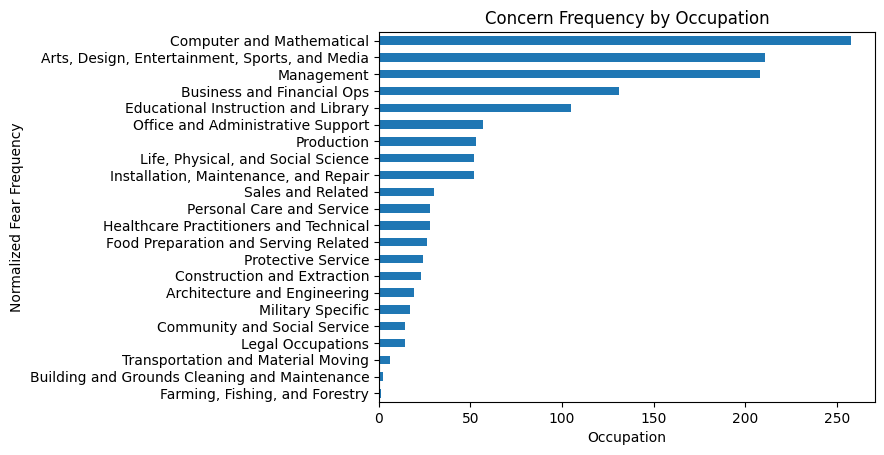

In [57]:
import matplotlib.pyplot as plt
data_dir = "/content/drive/MyDrive/SMM"
fear_df = pd.read_csv(Path(data_dir, 'final_fear_occupation_datset.csv'), encoding='unicode_escape',)

fear_only_df = fear_df[fear_df["fear?"] == 1]
fear_counts = fear_only_df['occupation'].value_counts()

# others_count = occupation_counts[occupation_counts < 10].sum()
# occupation_counts = occupation_counts[occupation_counts >= 10]
# occupation_counts['Others'] = others_count
ax = fear_counts.sort_values(ascending=True).plot(kind='barh', xlabel='Occupation', ylabel='Normalized Fear Frequency')
ax.set_title('Concern Frequency by Occupation')

Text(0.5, 1.0, 'Normalized Concern Frequency by Occupation')

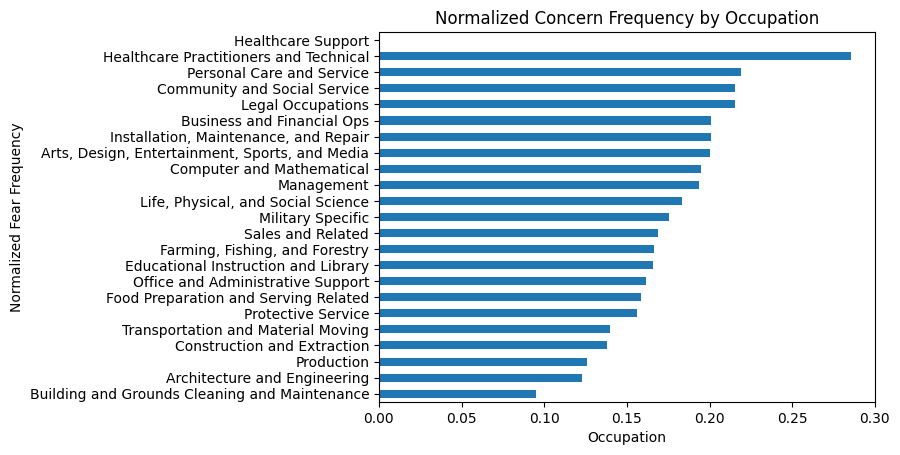

In [58]:
total_fear_counts = fear_df['occupation'].value_counts()
normalized_fear_counts = fear_counts / total_fear_counts
ax = normalized_fear_counts.sort_values(ascending=True).plot(kind='barh', xlabel='Occupation', ylabel='Normalized Fear Frequency')
ax.set_title('Normalized Concern Frequency by Occupation')

Text(0.5, 1.0, 'Toxicity Frequency by Occupation')

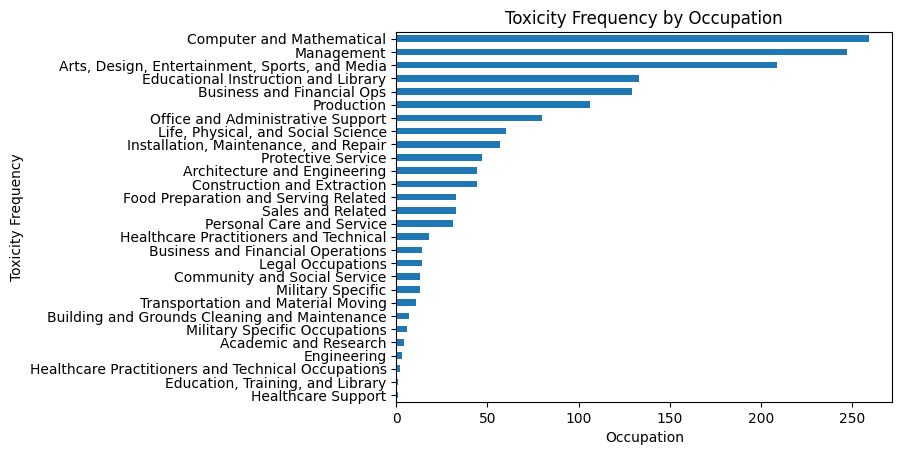

In [36]:
data_dir = "/content/drive/MyDrive/SMM"
toxic_df = pd.read_csv(Path(data_dir, 'final_toxic_occupation_datset.csv'), encoding='unicode_escape',)

toxic_only_df = toxic_df[(toxic_df["toxic"] == 1) | (toxic_df["severe_toxic"] == 1) | (toxic_df["obscene"] == 1) | (toxic_df["threat"] == 1) | (toxic_df["insult"] == 1) | (toxic_df["identity_hate"] == 1)]
toxic_ones_count = toxic_only_df['occupation'].value_counts()
ax = toxic_ones_count.sort_values(ascending=True).plot(kind='barh', xlabel='Occupation', ylabel='Toxicity Frequency')
ax.set_title('Toxicity Frequency by Occupation')

Text(0.5, 1.0, 'Normalized Toxicity Frequency by Occupation')

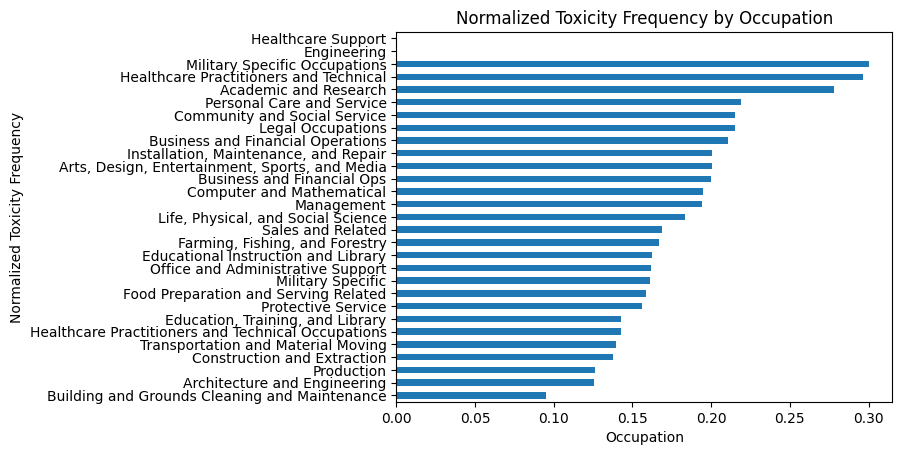

In [37]:
total_toxic_counts = toxic_df['occupation'].value_counts()
normalized_toxic_counts = toxic_ones_count / total_toxic_counts
ax = normalized_fear_counts.sort_values(ascending=True).plot(kind='barh', xlabel='Occupation', ylabel='Normalized Toxicity Frequency')
ax.set_title('Normalized Toxicity Frequency by Occupation')